# **Implementing Generative Adversial Networks(GANs) on MNIST dataset**

## **Importing Libraries**

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as data
device = torch.device("cuda")

## **Loading and Transforming Dataset**

In [3]:
trans = transforms.Compose([transforms.ToTensor()])
traindata = MNIST(root='./data', transform=trans, train=True, download=True)
trainloader = data.DataLoader(traindata, batch_size = 100, shuffle=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def plotimg(array, axis, i, j):
    # array = array.detach()
    array = array.reshape(28,28)
    
    axis[i, j].imshow(array,cmap='binary')

## **Defining the Generator Network**

In [5]:
class Generator(nn.Module):
    def __init__(self, n_features, n_out):
        super(Generator,self).__init__()
        
        self.hlayer1 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hlayer2 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hlayer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hlayer1(x)
        x = self.hlayer2(x)
        x = self.hlayer3(x)
        x = self.out(x)
        return x

## **Defining the Discriminator Network**

In [6]:
class Discriminator(nn.Module):
    
    def __init__(self, n_features, n_out):
        super(Discriminator,self).__init__()
        
        self.hlayer1 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hlayer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hlayer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hlayer1(x)
        x = self.hlayer2(x)
        x = self.hlayer3(x)
        x = self.out(x)
        return x

In [7]:
batch_size = 100
def noise(batch_size):
  # if is_cuda:
  #    return torch.randn(batch_size,100).cuda()
  return torch.randn(batch_size,100)

In [8]:
discriminator = Discriminator(784, 1)
generator = Generator(100, 784)

discriminator = discriminator.to(device)
generator = generator.to(device)


# if is_cuda:
#   discriminator.to(device)
#   generator.to(device)

In [9]:
criterion_d = nn.BCELoss()
discrim_optim = optim.SGD(discriminator.parameters(), lr= 0.0003, momentum=0.9)

criterion_g = nn.BCELoss()
generate_optim = optim.SGD(generator.parameters(), lr=0.0003, momentum=0.9)

## **Function to train the Discriminator Network**

In [31]:
def train_discriminator(optimizer, loss, real_data, fake_data):
    N = real_data.size(0)
    optimizer.zero_grad()
    # real_data = real_data.cuda() if is_cuda else real_data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, Variable(torch.ones(N, 1)).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, Variable(torch.zeros(N, 1)).to(device))
    error_fake.backward()
    optimizer.step()
    
    error_fake = error_fake.detach().cpu().numpy()
    error_real = error_real.detach().cpu().numpy()
    prediction_real = prediction_real.detach().cpu().numpy()
    prediction_fake = prediction_fake.detach().cpu().numpy()

    
    return error_real + error_fake, prediction_real, prediction_fake

##**Function to train Generator Network**

In [32]:
def train_generator(optimizer, loss, fake_data):
    N = fake_data.size(0)
    optimizer.zero_grad()
    # fake_data = fake_data.cuda() if is_cuda else fake_data
    prediction = discriminator(fake_data)
    error = loss(prediction, Variable(torch.ones(N, 1)).to(device))
    error.backward()

    optimizer.step()
    
    error = error.detach().cpu().numpy()

    
    return error

In [29]:
test_samples = 9
validation_noise = noise(test_samples)
gen_err = []
dis_err = []

##**Training**

Epoch: 0
	Batch: 1	Discriminator Error: 0.402038	Generator Error: 2.872070
	Batch: 200	Discriminator Error: 0.868930	Generator Error: 2.541416
	Batch: 400	Discriminator Error: 0.280311	Generator Error: 2.387889
	Batch: 600	Discriminator Error: 0.689922	Generator Error: 2.815854


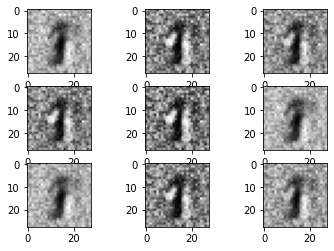

Epoch: 1
	Batch: 1	Discriminator Error: 0.595664	Generator Error: 2.720183
	Batch: 200	Discriminator Error: 0.364241	Generator Error: 2.864573
	Batch: 400	Discriminator Error: 0.174532	Generator Error: 2.787633
	Batch: 600	Discriminator Error: 0.280675	Generator Error: 2.763167


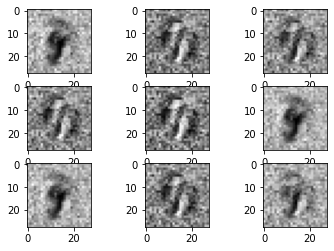

Epoch: 2
	Batch: 1	Discriminator Error: 0.255537	Generator Error: 2.753406
	Batch: 200	Discriminator Error: 0.358819	Generator Error: 3.675776
	Batch: 400	Discriminator Error: 0.474328	Generator Error: 2.629723
	Batch: 600	Discriminator Error: 0.336754	Generator Error: 3.424133


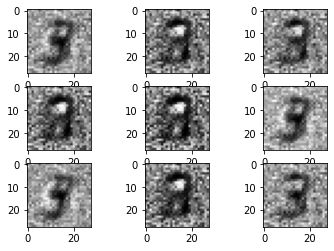

Epoch: 3
	Batch: 1	Discriminator Error: 0.221440	Generator Error: 3.218050
	Batch: 200	Discriminator Error: 0.309586	Generator Error: 2.609899
	Batch: 400	Discriminator Error: 0.777409	Generator Error: 2.589552
	Batch: 600	Discriminator Error: 0.390810	Generator Error: 2.137471


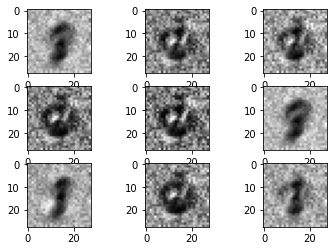

Epoch: 4
	Batch: 1	Discriminator Error: 0.435702	Generator Error: 2.199547
	Batch: 200	Discriminator Error: 0.227835	Generator Error: 2.491485
	Batch: 400	Discriminator Error: 0.258705	Generator Error: 2.557024
	Batch: 600	Discriminator Error: 0.540493	Generator Error: 2.656184


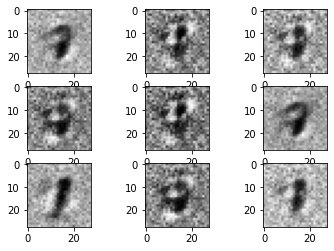

Epoch: 5
	Batch: 1	Discriminator Error: 0.564488	Generator Error: 2.574461
	Batch: 200	Discriminator Error: 0.293574	Generator Error: 2.983624
	Batch: 400	Discriminator Error: 0.346950	Generator Error: 2.379450
	Batch: 600	Discriminator Error: 0.327523	Generator Error: 2.889095


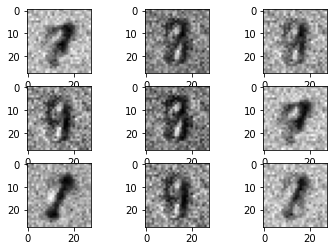

Epoch: 6
	Batch: 1	Discriminator Error: 0.251851	Generator Error: 2.828222
	Batch: 200	Discriminator Error: 0.225360	Generator Error: 3.097422
	Batch: 400	Discriminator Error: 0.323470	Generator Error: 2.626721
	Batch: 600	Discriminator Error: 0.273871	Generator Error: 2.987819


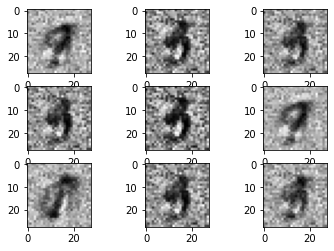

Epoch: 7
	Batch: 1	Discriminator Error: 0.256614	Generator Error: 3.069398
	Batch: 200	Discriminator Error: 0.448159	Generator Error: 2.524698
	Batch: 400	Discriminator Error: 0.311471	Generator Error: 2.753283
	Batch: 600	Discriminator Error: 0.280349	Generator Error: 3.471208


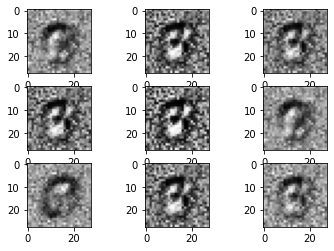

Epoch: 8
	Batch: 1	Discriminator Error: 0.367647	Generator Error: 3.371907
	Batch: 200	Discriminator Error: 0.314376	Generator Error: 2.887475
	Batch: 400	Discriminator Error: 0.202015	Generator Error: 3.114010
	Batch: 600	Discriminator Error: 0.315511	Generator Error: 2.683387


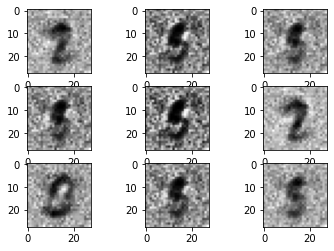

Epoch: 9
	Batch: 1	Discriminator Error: 0.321492	Generator Error: 2.653086
	Batch: 200	Discriminator Error: 0.483312	Generator Error: 2.964583
	Batch: 400	Discriminator Error: 0.293239	Generator Error: 2.693354
	Batch: 600	Discriminator Error: 0.316239	Generator Error: 2.911080


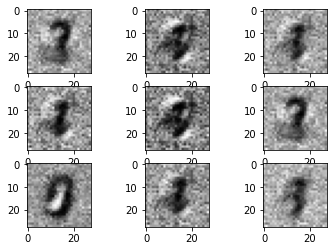

Epoch: 10
	Batch: 1	Discriminator Error: 0.268146	Generator Error: 2.751144
	Batch: 200	Discriminator Error: 0.296771	Generator Error: 2.817699
	Batch: 400	Discriminator Error: 0.380344	Generator Error: 3.264012
	Batch: 600	Discriminator Error: 0.430648	Generator Error: 2.682584


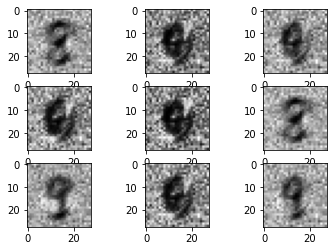

Epoch: 11
	Batch: 1	Discriminator Error: 0.354670	Generator Error: 2.807508
	Batch: 200	Discriminator Error: 0.184409	Generator Error: 3.056734
	Batch: 400	Discriminator Error: 0.337991	Generator Error: 2.920733
	Batch: 600	Discriminator Error: 0.239722	Generator Error: 3.434521


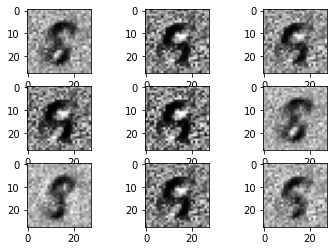

Epoch: 12
	Batch: 1	Discriminator Error: 0.206325	Generator Error: 3.497526
	Batch: 200	Discriminator Error: 0.493396	Generator Error: 3.098012
	Batch: 400	Discriminator Error: 0.346403	Generator Error: 2.985615
	Batch: 600	Discriminator Error: 0.322046	Generator Error: 3.078734


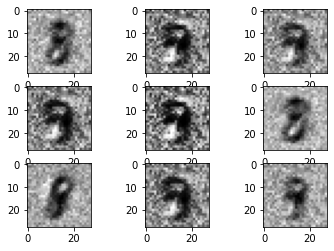

Epoch: 13
	Batch: 1	Discriminator Error: 0.259062	Generator Error: 3.086512
	Batch: 200	Discriminator Error: 0.414880	Generator Error: 2.959896
	Batch: 400	Discriminator Error: 0.262268	Generator Error: 3.106889
	Batch: 600	Discriminator Error: 0.235938	Generator Error: 4.157713


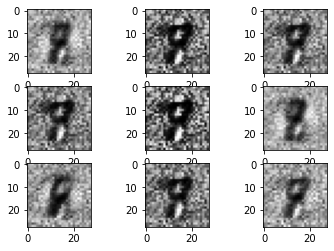

Epoch: 14
	Batch: 1	Discriminator Error: 0.317429	Generator Error: 4.091139
	Batch: 200	Discriminator Error: 0.372391	Generator Error: 3.057897
	Batch: 400	Discriminator Error: 0.293896	Generator Error: 2.936271
	Batch: 600	Discriminator Error: 0.408142	Generator Error: 2.895006


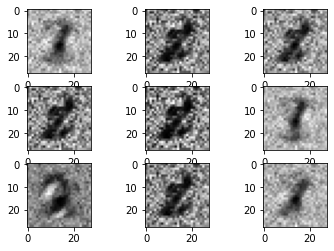

Epoch: 15
	Batch: 1	Discriminator Error: 0.326962	Generator Error: 2.997834
	Batch: 200	Discriminator Error: 0.248979	Generator Error: 3.777890
	Batch: 400	Discriminator Error: 0.268795	Generator Error: 3.132167
	Batch: 600	Discriminator Error: 0.363566	Generator Error: 3.117421


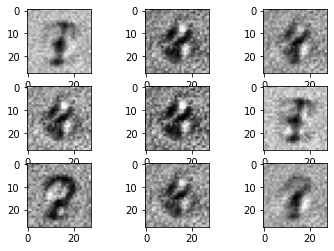

Epoch: 16
	Batch: 1	Discriminator Error: 0.311599	Generator Error: 3.133121
	Batch: 200	Discriminator Error: 0.403741	Generator Error: 3.139090
	Batch: 400	Discriminator Error: 0.519800	Generator Error: 2.962153
	Batch: 600	Discriminator Error: 0.233047	Generator Error: 3.043424


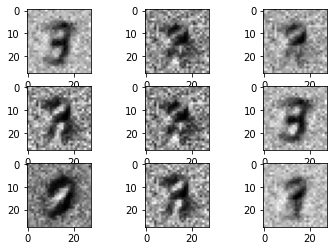

Epoch: 17
	Batch: 1	Discriminator Error: 0.238906	Generator Error: 3.100254
	Batch: 200	Discriminator Error: 0.300306	Generator Error: 2.949374
	Batch: 400	Discriminator Error: 0.334189	Generator Error: 3.041854
	Batch: 600	Discriminator Error: 0.293390	Generator Error: 3.075927


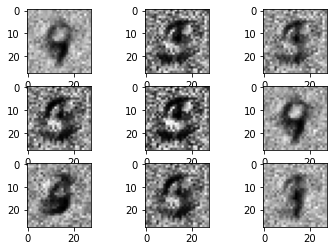

Epoch: 18
	Batch: 1	Discriminator Error: 0.309094	Generator Error: 3.120269
	Batch: 200	Discriminator Error: 0.326746	Generator Error: 3.891838
	Batch: 400	Discriminator Error: 0.356095	Generator Error: 3.004651
	Batch: 600	Discriminator Error: 0.313467	Generator Error: 3.070188


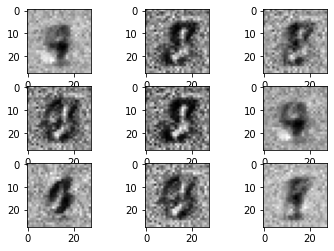

Epoch: 19
	Batch: 1	Discriminator Error: 0.288138	Generator Error: 3.025074
	Batch: 200	Discriminator Error: 0.435637	Generator Error: 2.840722
	Batch: 400	Discriminator Error: 0.318658	Generator Error: 3.441925
	Batch: 600	Discriminator Error: 0.367258	Generator Error: 2.808059


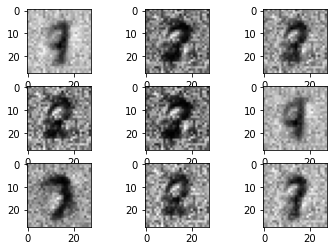

Epoch: 20
	Batch: 1	Discriminator Error: 0.238823	Generator Error: 2.792781
	Batch: 200	Discriminator Error: 0.110912	Generator Error: 3.066702
	Batch: 400	Discriminator Error: 0.349405	Generator Error: 3.011726
	Batch: 600	Discriminator Error: 0.374413	Generator Error: 3.406718


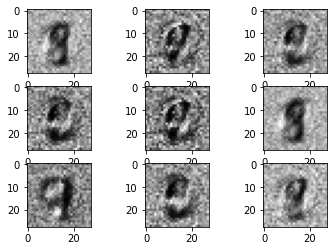

Epoch: 21
	Batch: 1	Discriminator Error: 0.260708	Generator Error: 3.280042
	Batch: 200	Discriminator Error: 0.355651	Generator Error: 3.311231
	Batch: 400	Discriminator Error: 0.405378	Generator Error: 3.108978
	Batch: 600	Discriminator Error: 0.446558	Generator Error: 3.388414


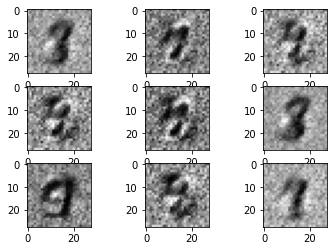

Epoch: 22
	Batch: 1	Discriminator Error: 0.290410	Generator Error: 3.218633
	Batch: 200	Discriminator Error: 0.454114	Generator Error: 3.216413
	Batch: 400	Discriminator Error: 0.503469	Generator Error: 3.045881
	Batch: 600	Discriminator Error: 0.277985	Generator Error: 3.155678


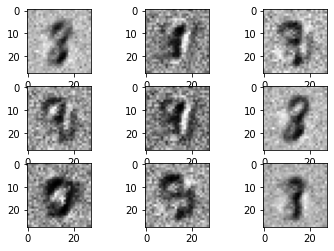

Epoch: 23
	Batch: 1	Discriminator Error: 0.212905	Generator Error: 3.175577
	Batch: 200	Discriminator Error: 0.226154	Generator Error: 3.165434
	Batch: 400	Discriminator Error: 0.285813	Generator Error: 2.949491
	Batch: 600	Discriminator Error: 0.269703	Generator Error: 3.375754


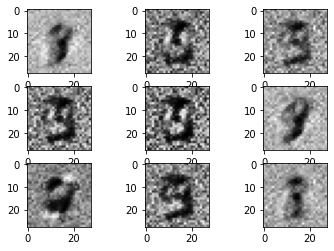

Epoch: 24
	Batch: 1	Discriminator Error: 0.218183	Generator Error: 3.558344
	Batch: 200	Discriminator Error: 0.443063	Generator Error: 3.195087
	Batch: 400	Discriminator Error: 0.211413	Generator Error: 3.566774
	Batch: 600	Discriminator Error: 0.286932	Generator Error: 3.143549


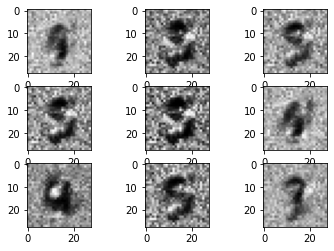

Epoch: 25
	Batch: 1	Discriminator Error: 0.253771	Generator Error: 3.184521
	Batch: 200	Discriminator Error: 0.342043	Generator Error: 3.177424
	Batch: 400	Discriminator Error: 0.203747	Generator Error: 3.409445
	Batch: 600	Discriminator Error: 0.322859	Generator Error: 3.339540


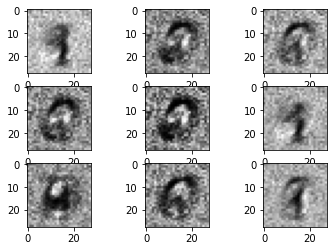

Epoch: 26
	Batch: 1	Discriminator Error: 0.329201	Generator Error: 3.094167
	Batch: 200	Discriminator Error: 0.495449	Generator Error: 3.960409
	Batch: 400	Discriminator Error: 0.281121	Generator Error: 3.015605
	Batch: 600	Discriminator Error: 0.166703	Generator Error: 3.235935


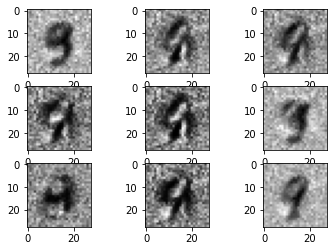

Epoch: 27
	Batch: 1	Discriminator Error: 0.126728	Generator Error: 3.433236
	Batch: 200	Discriminator Error: 0.379771	Generator Error: 3.053096
	Batch: 400	Discriminator Error: 0.165035	Generator Error: 3.496821
	Batch: 600	Discriminator Error: 0.306829	Generator Error: 3.003924


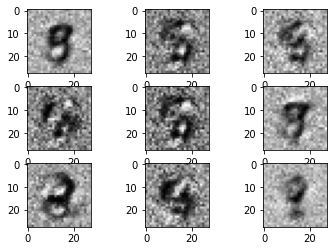

Epoch: 28
	Batch: 1	Discriminator Error: 0.406048	Generator Error: 2.819568
	Batch: 200	Discriminator Error: 0.335330	Generator Error: 3.245843
	Batch: 400	Discriminator Error: 0.258384	Generator Error: 3.346411
	Batch: 600	Discriminator Error: 0.398318	Generator Error: 3.356593


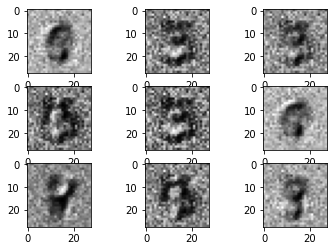

Epoch: 29
	Batch: 1	Discriminator Error: 0.505246	Generator Error: 3.257892
	Batch: 200	Discriminator Error: 0.292887	Generator Error: 3.534248
	Batch: 400	Discriminator Error: 0.297409	Generator Error: 3.176173
	Batch: 600	Discriminator Error: 0.248391	Generator Error: 3.351590


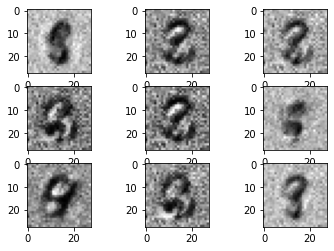

Epoch: 30
	Batch: 1	Discriminator Error: 0.270790	Generator Error: 3.403703
	Batch: 200	Discriminator Error: 0.163633	Generator Error: 3.269283
	Batch: 400	Discriminator Error: 0.295622	Generator Error: 3.283533
	Batch: 600	Discriminator Error: 0.236549	Generator Error: 3.768918


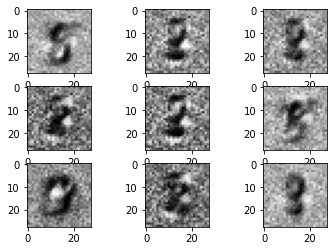

Epoch: 31
	Batch: 1	Discriminator Error: 0.329961	Generator Error: 4.038380
	Batch: 200	Discriminator Error: 0.462356	Generator Error: 3.231139
	Batch: 400	Discriminator Error: 0.363957	Generator Error: 3.459419
	Batch: 600	Discriminator Error: 0.221970	Generator Error: 3.394064


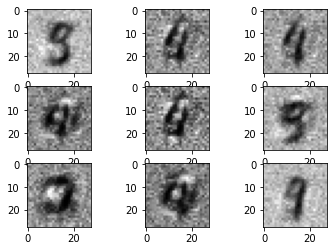

Epoch: 32
	Batch: 1	Discriminator Error: 0.302860	Generator Error: 3.199512
	Batch: 200	Discriminator Error: 0.378228	Generator Error: 3.322396
	Batch: 400	Discriminator Error: 0.278972	Generator Error: 3.506326
	Batch: 600	Discriminator Error: 0.271722	Generator Error: 3.280067


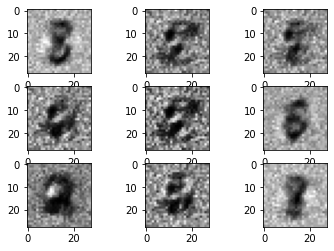

Epoch: 33
	Batch: 1	Discriminator Error: 0.213090	Generator Error: 3.289633
	Batch: 200	Discriminator Error: 0.301870	Generator Error: 3.445791
	Batch: 400	Discriminator Error: 0.343110	Generator Error: 3.576964
	Batch: 600	Discriminator Error: 0.316531	Generator Error: 3.322016


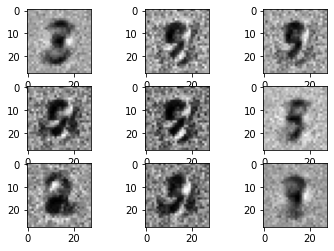

Epoch: 34
	Batch: 1	Discriminator Error: 0.375481	Generator Error: 3.307233
	Batch: 200	Discriminator Error: 0.221898	Generator Error: 3.187123
	Batch: 400	Discriminator Error: 0.344771	Generator Error: 3.414113
	Batch: 600	Discriminator Error: 0.328008	Generator Error: 3.113980


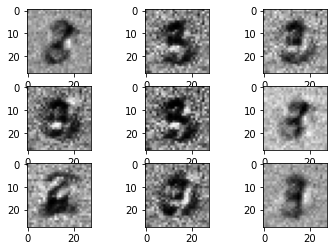

Epoch: 35
	Batch: 1	Discriminator Error: 0.291282	Generator Error: 2.940315
	Batch: 200	Discriminator Error: 0.255422	Generator Error: 3.659974
	Batch: 400	Discriminator Error: 0.300799	Generator Error: 3.339322
	Batch: 600	Discriminator Error: 0.304052	Generator Error: 3.356437


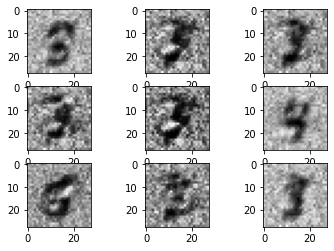

Epoch: 36
	Batch: 1	Discriminator Error: 0.405619	Generator Error: 3.397942
	Batch: 200	Discriminator Error: 0.270876	Generator Error: 3.477321
	Batch: 400	Discriminator Error: 0.403521	Generator Error: 3.628472
	Batch: 600	Discriminator Error: 0.191452	Generator Error: 3.549405


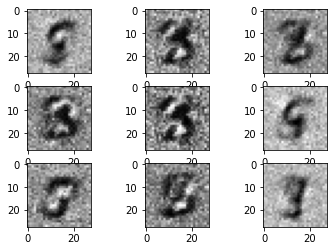

Epoch: 37
	Batch: 1	Discriminator Error: 0.158283	Generator Error: 3.665853
	Batch: 200	Discriminator Error: 0.334755	Generator Error: 3.255871
	Batch: 400	Discriminator Error: 0.196599	Generator Error: 3.517424
	Batch: 600	Discriminator Error: 0.253562	Generator Error: 3.218151


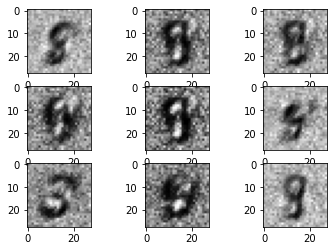

Epoch: 38
	Batch: 1	Discriminator Error: 0.448487	Generator Error: 3.371838
	Batch: 200	Discriminator Error: 0.179656	Generator Error: 3.373301
	Batch: 400	Discriminator Error: 0.407518	Generator Error: 3.358902
	Batch: 600	Discriminator Error: 0.353002	Generator Error: 3.608557


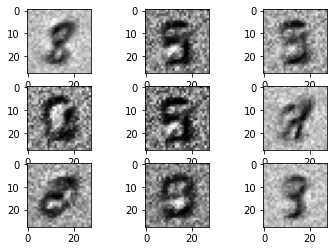

Epoch: 39
	Batch: 1	Discriminator Error: 0.257261	Generator Error: 3.561652
	Batch: 200	Discriminator Error: 0.391261	Generator Error: 3.102592
	Batch: 400	Discriminator Error: 0.275297	Generator Error: 3.353588
	Batch: 600	Discriminator Error: 0.311796	Generator Error: 3.366122


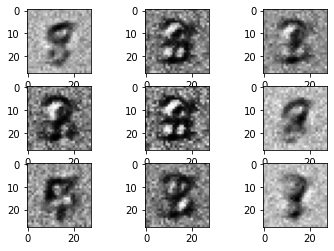

Epoch: 40
	Batch: 1	Discriminator Error: 0.180017	Generator Error: 3.526213
	Batch: 200	Discriminator Error: 0.203942	Generator Error: 3.189958
	Batch: 400	Discriminator Error: 0.162309	Generator Error: 3.605075
	Batch: 600	Discriminator Error: 0.252950	Generator Error: 3.295976


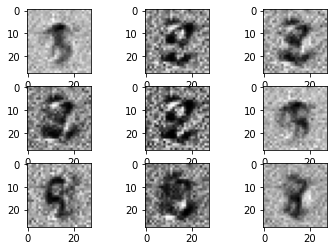

Epoch: 41
	Batch: 1	Discriminator Error: 0.313882	Generator Error: 3.510988
	Batch: 200	Discriminator Error: 0.222219	Generator Error: 3.394020
	Batch: 400	Discriminator Error: 0.316952	Generator Error: 3.350925
	Batch: 600	Discriminator Error: 0.502042	Generator Error: 2.922961


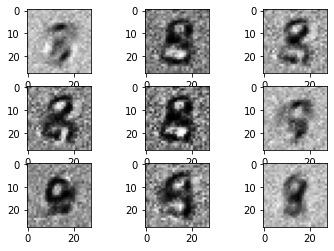

Epoch: 42
	Batch: 1	Discriminator Error: 0.366950	Generator Error: 2.953516
	Batch: 200	Discriminator Error: 0.343813	Generator Error: 3.081587
	Batch: 400	Discriminator Error: 0.301930	Generator Error: 3.604924
	Batch: 600	Discriminator Error: 0.249375	Generator Error: 3.482540


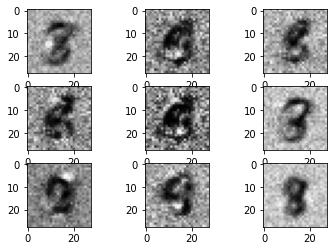

Epoch: 43
	Batch: 1	Discriminator Error: 0.192255	Generator Error: 3.301623
	Batch: 200	Discriminator Error: 0.289057	Generator Error: 3.434278
	Batch: 400	Discriminator Error: 0.359817	Generator Error: 3.584329
	Batch: 600	Discriminator Error: 0.302290	Generator Error: 3.266947


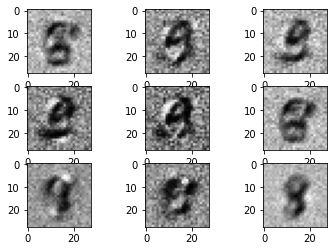

Epoch: 44
	Batch: 1	Discriminator Error: 0.407157	Generator Error: 3.505811
	Batch: 200	Discriminator Error: 0.333259	Generator Error: 3.600745
	Batch: 400	Discriminator Error: 0.313246	Generator Error: 3.079910
	Batch: 600	Discriminator Error: 0.222519	Generator Error: 3.431328


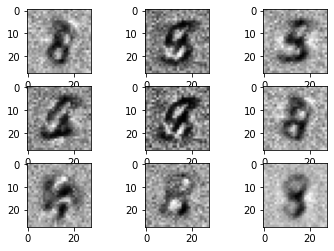

Epoch: 45
	Batch: 1	Discriminator Error: 0.208534	Generator Error: 3.289992
	Batch: 200	Discriminator Error: 0.249673	Generator Error: 3.404809
	Batch: 400	Discriminator Error: 0.200228	Generator Error: 3.321392
	Batch: 600	Discriminator Error: 0.327223	Generator Error: 3.337911


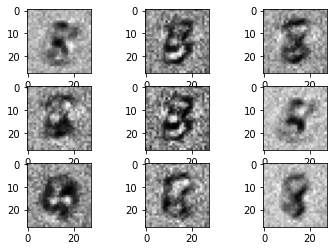

Epoch: 46
	Batch: 1	Discriminator Error: 0.253838	Generator Error: 3.472706
	Batch: 200	Discriminator Error: 0.313964	Generator Error: 3.121477
	Batch: 400	Discriminator Error: 0.344427	Generator Error: 3.588700
	Batch: 600	Discriminator Error: 0.355268	Generator Error: 3.267790


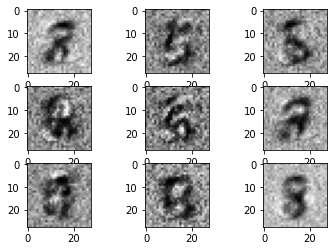

Epoch: 47
	Batch: 1	Discriminator Error: 0.330915	Generator Error: 3.291879
	Batch: 200	Discriminator Error: 0.400857	Generator Error: 3.094590
	Batch: 400	Discriminator Error: 0.278424	Generator Error: 3.747918
	Batch: 600	Discriminator Error: 0.271384	Generator Error: 3.677700


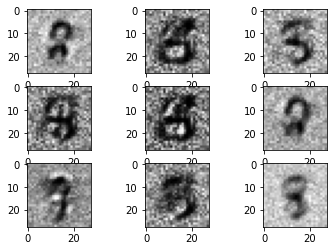

Epoch: 48
	Batch: 1	Discriminator Error: 0.236688	Generator Error: 3.474559
	Batch: 200	Discriminator Error: 0.285454	Generator Error: 3.177379
	Batch: 400	Discriminator Error: 0.285263	Generator Error: 3.618413
	Batch: 600	Discriminator Error: 0.269380	Generator Error: 3.467411


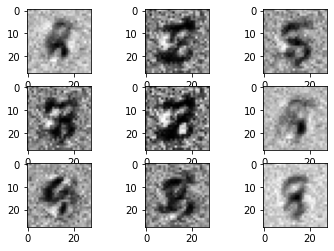

Epoch: 49
	Batch: 1	Discriminator Error: 0.254567	Generator Error: 3.353831
	Batch: 200	Discriminator Error: 0.241102	Generator Error: 3.131304
	Batch: 400	Discriminator Error: 0.326854	Generator Error: 3.580607
	Batch: 600	Discriminator Error: 0.218582	Generator Error: 3.288259


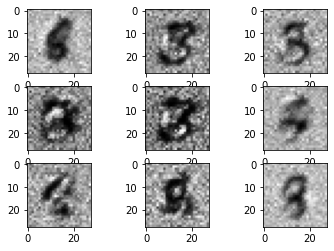

Epoch: 50
	Batch: 1	Discriminator Error: 0.255485	Generator Error: 3.518308
	Batch: 200	Discriminator Error: 0.307642	Generator Error: 3.547904
	Batch: 400	Discriminator Error: 0.202898	Generator Error: 3.522573
	Batch: 600	Discriminator Error: 0.426645	Generator Error: 3.147944


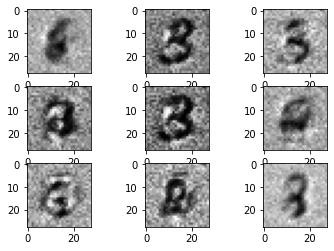

Epoch: 51
	Batch: 1	Discriminator Error: 0.334458	Generator Error: 3.327252
	Batch: 200	Discriminator Error: 0.287478	Generator Error: 3.463233
	Batch: 400	Discriminator Error: 0.286858	Generator Error: 3.870102
	Batch: 600	Discriminator Error: 0.344502	Generator Error: 3.439799


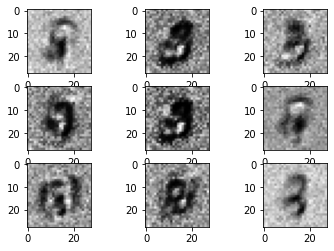

Epoch: 52
	Batch: 1	Discriminator Error: 0.344978	Generator Error: 3.733037
	Batch: 200	Discriminator Error: 0.312920	Generator Error: 3.646676
	Batch: 400	Discriminator Error: 0.292268	Generator Error: 3.350463
	Batch: 600	Discriminator Error: 0.295139	Generator Error: 3.477404


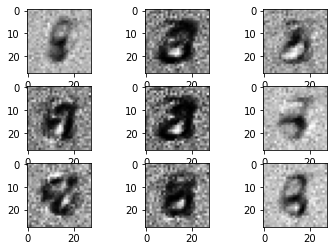

Epoch: 53
	Batch: 1	Discriminator Error: 0.288285	Generator Error: 3.626643
	Batch: 200	Discriminator Error: 0.248335	Generator Error: 4.060778
	Batch: 400	Discriminator Error: 0.206807	Generator Error: 3.461946
	Batch: 600	Discriminator Error: 0.298827	Generator Error: 3.087667


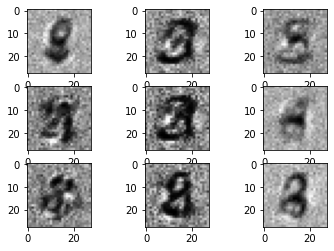

Epoch: 54
	Batch: 1	Discriminator Error: 0.354460	Generator Error: 3.331637
	Batch: 200	Discriminator Error: 0.337221	Generator Error: 3.393915
	Batch: 400	Discriminator Error: 0.202163	Generator Error: 3.340270
	Batch: 600	Discriminator Error: 0.255948	Generator Error: 3.615850


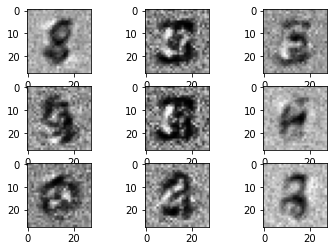

Epoch: 55
	Batch: 1	Discriminator Error: 0.330557	Generator Error: 3.597143
	Batch: 200	Discriminator Error: 0.186722	Generator Error: 3.781007
	Batch: 400	Discriminator Error: 0.215596	Generator Error: 3.460651
	Batch: 600	Discriminator Error: 0.208909	Generator Error: 3.586905


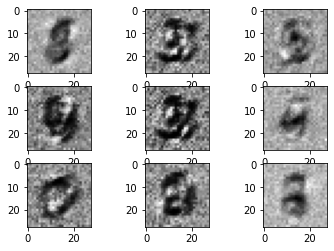

Epoch: 56
	Batch: 1	Discriminator Error: 0.337139	Generator Error: 3.440611
	Batch: 200	Discriminator Error: 0.300430	Generator Error: 3.372724
	Batch: 400	Discriminator Error: 0.244035	Generator Error: 3.572211
	Batch: 600	Discriminator Error: 0.233551	Generator Error: 3.731736


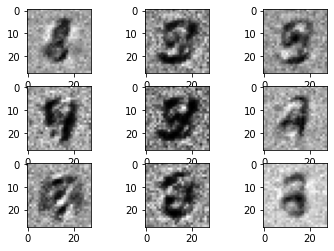

Epoch: 57
	Batch: 1	Discriminator Error: 0.331857	Generator Error: 3.719828
	Batch: 200	Discriminator Error: 0.249692	Generator Error: 3.875400
	Batch: 400	Discriminator Error: 0.440544	Generator Error: 3.508615
	Batch: 600	Discriminator Error: 0.369850	Generator Error: 3.389131


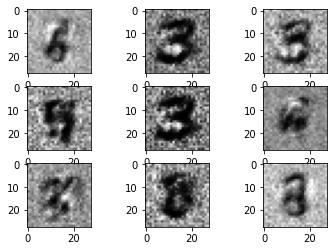

Epoch: 58
	Batch: 1	Discriminator Error: 0.235446	Generator Error: 3.406565
	Batch: 200	Discriminator Error: 0.276777	Generator Error: 3.232723
	Batch: 400	Discriminator Error: 0.304967	Generator Error: 3.458235
	Batch: 600	Discriminator Error: 0.329195	Generator Error: 3.359936


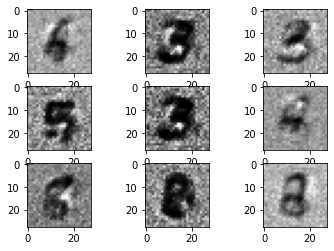

Epoch: 59
	Batch: 1	Discriminator Error: 0.459366	Generator Error: 3.386519
	Batch: 200	Discriminator Error: 0.303970	Generator Error: 3.165205
	Batch: 400	Discriminator Error: 0.224643	Generator Error: 3.657018
	Batch: 600	Discriminator Error: 0.315330	Generator Error: 3.602818


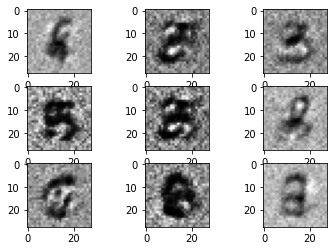

Epoch: 60
	Batch: 1	Discriminator Error: 0.371321	Generator Error: 3.513738
	Batch: 200	Discriminator Error: 0.338064	Generator Error: 3.463643
	Batch: 400	Discriminator Error: 0.320647	Generator Error: 3.321963
	Batch: 600	Discriminator Error: 0.374792	Generator Error: 3.608791


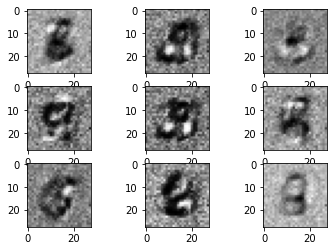

Epoch: 61
	Batch: 1	Discriminator Error: 0.374848	Generator Error: 3.400212
	Batch: 200	Discriminator Error: 0.236161	Generator Error: 3.548448
	Batch: 400	Discriminator Error: 0.240284	Generator Error: 3.233929
	Batch: 600	Discriminator Error: 0.279573	Generator Error: 3.212657


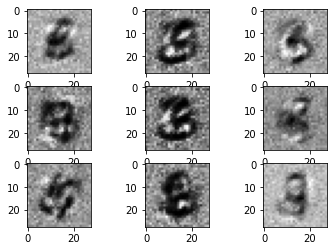

Epoch: 62
	Batch: 1	Discriminator Error: 0.339269	Generator Error: 3.104933
	Batch: 200	Discriminator Error: 0.341199	Generator Error: 3.471445
	Batch: 400	Discriminator Error: 0.228249	Generator Error: 3.446214
	Batch: 600	Discriminator Error: 0.425355	Generator Error: 3.388266


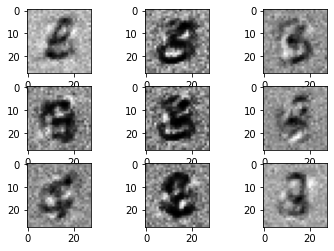

Epoch: 63
	Batch: 1	Discriminator Error: 0.365410	Generator Error: 3.685997
	Batch: 200	Discriminator Error: 0.299795	Generator Error: 3.070098
	Batch: 400	Discriminator Error: 0.184614	Generator Error: 3.619318
	Batch: 600	Discriminator Error: 0.289852	Generator Error: 3.515083


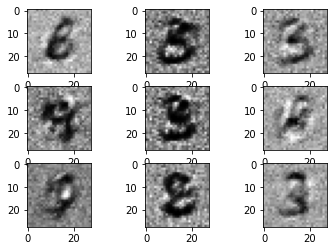

Epoch: 64
	Batch: 1	Discriminator Error: 0.234971	Generator Error: 3.713182
	Batch: 200	Discriminator Error: 0.331798	Generator Error: 3.316316
	Batch: 400	Discriminator Error: 0.311355	Generator Error: 3.397592
	Batch: 600	Discriminator Error: 0.316680	Generator Error: 3.280810


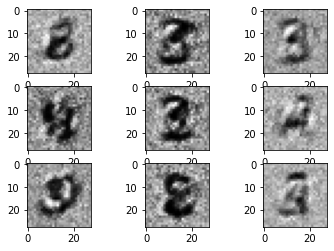

Epoch: 65
	Batch: 1	Discriminator Error: 0.279282	Generator Error: 3.422713
	Batch: 200	Discriminator Error: 0.308910	Generator Error: 3.586878
	Batch: 400	Discriminator Error: 0.426985	Generator Error: 3.570641
	Batch: 600	Discriminator Error: 0.221907	Generator Error: 3.588931


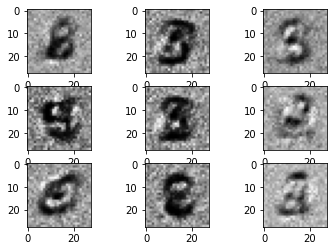

Epoch: 66
	Batch: 1	Discriminator Error: 0.448413	Generator Error: 3.592213
	Batch: 200	Discriminator Error: 0.349142	Generator Error: 3.581088
	Batch: 400	Discriminator Error: 0.363885	Generator Error: 3.170682
	Batch: 600	Discriminator Error: 0.340291	Generator Error: 3.350964


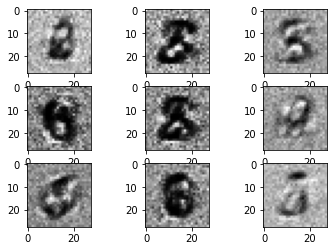

Epoch: 67
	Batch: 1	Discriminator Error: 0.480969	Generator Error: 3.083488
	Batch: 200	Discriminator Error: 0.254472	Generator Error: 3.214899
	Batch: 400	Discriminator Error: 0.454014	Generator Error: 3.163511
	Batch: 600	Discriminator Error: 0.335805	Generator Error: 3.273028


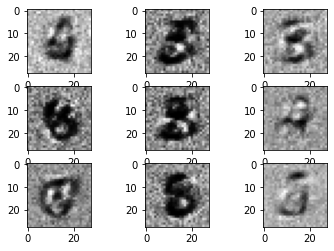

Epoch: 68
	Batch: 1	Discriminator Error: 0.401946	Generator Error: 3.347532
	Batch: 200	Discriminator Error: 0.396702	Generator Error: 3.298777
	Batch: 400	Discriminator Error: 0.335915	Generator Error: 3.549261
	Batch: 600	Discriminator Error: 0.243686	Generator Error: 3.154408


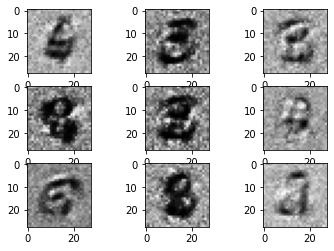

Epoch: 69
	Batch: 1	Discriminator Error: 0.355689	Generator Error: 3.228299
	Batch: 200	Discriminator Error: 0.327218	Generator Error: 3.786797
	Batch: 400	Discriminator Error: 0.295010	Generator Error: 3.528774
	Batch: 600	Discriminator Error: 0.223046	Generator Error: 3.222396


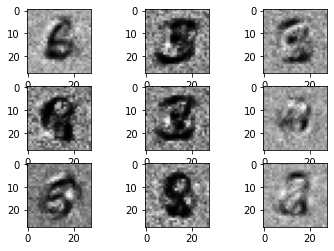

Epoch: 70
	Batch: 1	Discriminator Error: 0.243609	Generator Error: 3.286429
	Batch: 200	Discriminator Error: 0.401656	Generator Error: 3.605924
	Batch: 400	Discriminator Error: 0.344558	Generator Error: 3.510160
	Batch: 600	Discriminator Error: 0.384792	Generator Error: 3.266312


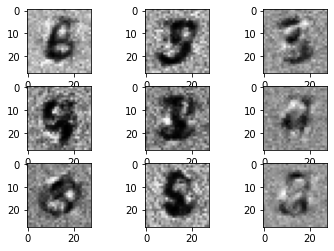

Epoch: 71
	Batch: 1	Discriminator Error: 0.335517	Generator Error: 3.270271
	Batch: 200	Discriminator Error: 0.337411	Generator Error: 2.780597
	Batch: 400	Discriminator Error: 0.412721	Generator Error: 3.099854
	Batch: 600	Discriminator Error: 0.366119	Generator Error: 2.984113


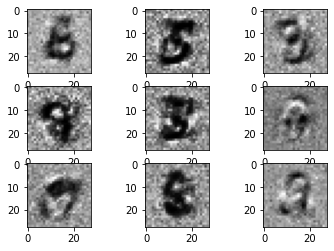

Epoch: 72
	Batch: 1	Discriminator Error: 0.404392	Generator Error: 2.800398
	Batch: 200	Discriminator Error: 0.376401	Generator Error: 3.034245
	Batch: 400	Discriminator Error: 0.234008	Generator Error: 3.221949
	Batch: 600	Discriminator Error: 0.260967	Generator Error: 3.056684


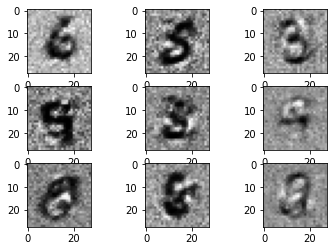

Epoch: 73
	Batch: 1	Discriminator Error: 0.336582	Generator Error: 3.410977
	Batch: 200	Discriminator Error: 0.396552	Generator Error: 2.896421
	Batch: 400	Discriminator Error: 0.292065	Generator Error: 3.138771
	Batch: 600	Discriminator Error: 0.330031	Generator Error: 3.590426


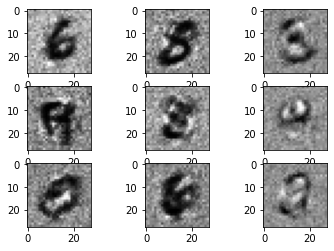

Epoch: 74
	Batch: 1	Discriminator Error: 0.368130	Generator Error: 3.372536
	Batch: 200	Discriminator Error: 0.494031	Generator Error: 3.459017
	Batch: 400	Discriminator Error: 0.305094	Generator Error: 3.466960
	Batch: 600	Discriminator Error: 0.430193	Generator Error: 3.319020


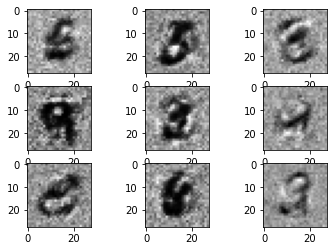

Epoch: 75
	Batch: 1	Discriminator Error: 0.356832	Generator Error: 3.272252
	Batch: 200	Discriminator Error: 0.468490	Generator Error: 3.159789
	Batch: 400	Discriminator Error: 0.324131	Generator Error: 3.378956
	Batch: 600	Discriminator Error: 0.300013	Generator Error: 2.872015


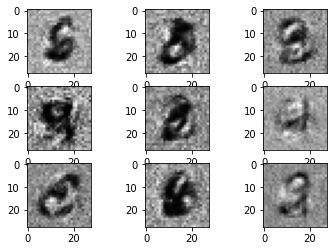

Epoch: 76
	Batch: 1	Discriminator Error: 0.321008	Generator Error: 3.090463
	Batch: 200	Discriminator Error: 0.397623	Generator Error: 3.089965
	Batch: 400	Discriminator Error: 0.393169	Generator Error: 3.354462
	Batch: 600	Discriminator Error: 0.342309	Generator Error: 3.048141


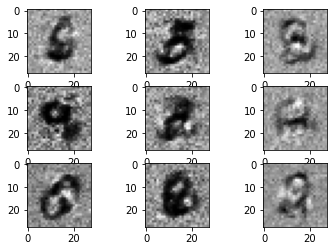

Epoch: 77
	Batch: 1	Discriminator Error: 0.285618	Generator Error: 3.084764
	Batch: 200	Discriminator Error: 0.388511	Generator Error: 3.245931
	Batch: 400	Discriminator Error: 0.497239	Generator Error: 3.074434
	Batch: 600	Discriminator Error: 0.408667	Generator Error: 3.361475


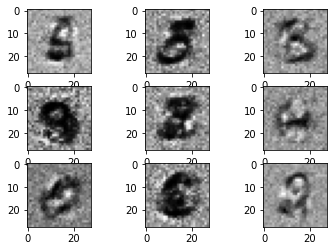

Epoch: 78
	Batch: 1	Discriminator Error: 0.328101	Generator Error: 3.419717
	Batch: 200	Discriminator Error: 0.391253	Generator Error: 2.938100
	Batch: 400	Discriminator Error: 0.460463	Generator Error: 2.914734
	Batch: 600	Discriminator Error: 0.397066	Generator Error: 3.510743


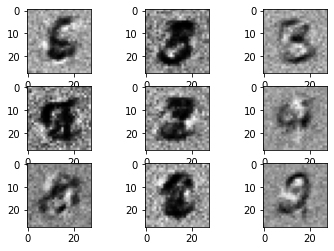

Epoch: 79
	Batch: 1	Discriminator Error: 0.379066	Generator Error: 3.226723
	Batch: 200	Discriminator Error: 0.252102	Generator Error: 3.339083
	Batch: 400	Discriminator Error: 0.301802	Generator Error: 3.113007
	Batch: 600	Discriminator Error: 0.298263	Generator Error: 3.118172


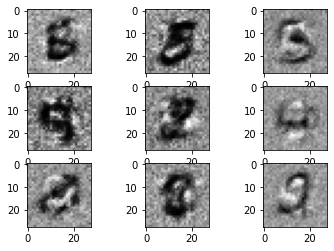

Epoch: 80
	Batch: 1	Discriminator Error: 0.229427	Generator Error: 3.244766
	Batch: 200	Discriminator Error: 0.349968	Generator Error: 3.273184
	Batch: 400	Discriminator Error: 0.321026	Generator Error: 3.107276
	Batch: 600	Discriminator Error: 0.243887	Generator Error: 3.603939


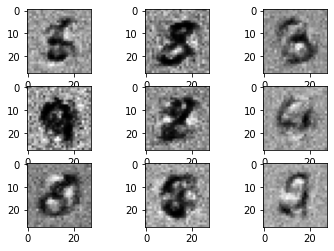

Epoch: 81
	Batch: 1	Discriminator Error: 0.269333	Generator Error: 3.375109
	Batch: 200	Discriminator Error: 0.316692	Generator Error: 3.183163
	Batch: 400	Discriminator Error: 0.346382	Generator Error: 3.132257
	Batch: 600	Discriminator Error: 0.335231	Generator Error: 2.933317


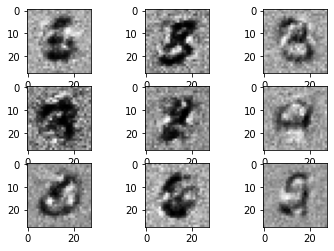

Epoch: 82
	Batch: 1	Discriminator Error: 0.312405	Generator Error: 2.877372
	Batch: 200	Discriminator Error: 0.378323	Generator Error: 3.205492
	Batch: 400	Discriminator Error: 0.403787	Generator Error: 3.237464
	Batch: 600	Discriminator Error: 0.393218	Generator Error: 3.200440


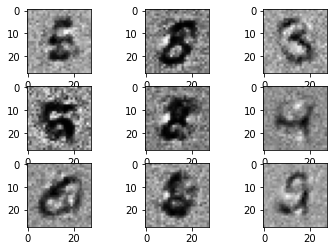

Epoch: 83
	Batch: 1	Discriminator Error: 0.379431	Generator Error: 3.374212
	Batch: 200	Discriminator Error: 0.306770	Generator Error: 3.217352
	Batch: 400	Discriminator Error: 0.410865	Generator Error: 2.657292
	Batch: 600	Discriminator Error: 0.312484	Generator Error: 3.137941


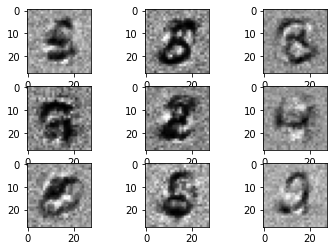

Epoch: 84
	Batch: 1	Discriminator Error: 0.354648	Generator Error: 2.899323
	Batch: 200	Discriminator Error: 0.374854	Generator Error: 2.989048
	Batch: 400	Discriminator Error: 0.317260	Generator Error: 3.259280
	Batch: 600	Discriminator Error: 0.327421	Generator Error: 3.212199


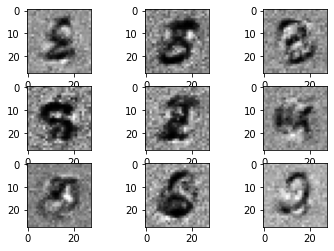

Epoch: 85
	Batch: 1	Discriminator Error: 0.294901	Generator Error: 3.037132
	Batch: 200	Discriminator Error: 0.328854	Generator Error: 2.808012
	Batch: 400	Discriminator Error: 0.381042	Generator Error: 3.205848
	Batch: 600	Discriminator Error: 0.336686	Generator Error: 3.254473


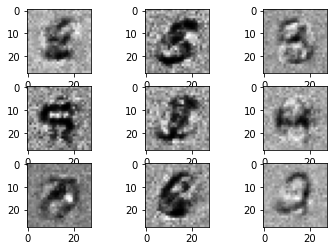

Epoch: 86
	Batch: 1	Discriminator Error: 0.402797	Generator Error: 3.286940
	Batch: 200	Discriminator Error: 0.428880	Generator Error: 2.847462
	Batch: 400	Discriminator Error: 0.430676	Generator Error: 3.054028
	Batch: 600	Discriminator Error: 0.327266	Generator Error: 2.961460


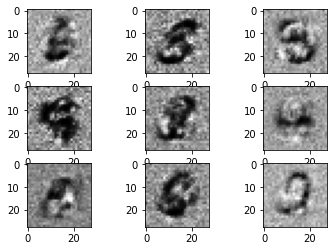

Epoch: 87
	Batch: 1	Discriminator Error: 0.276088	Generator Error: 3.212161
	Batch: 200	Discriminator Error: 0.408288	Generator Error: 3.150262
	Batch: 400	Discriminator Error: 0.437924	Generator Error: 3.239038
	Batch: 600	Discriminator Error: 0.328634	Generator Error: 3.488015


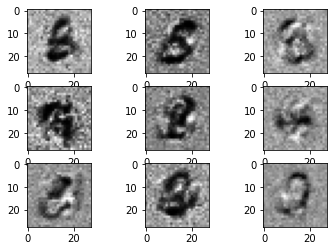

Epoch: 88
	Batch: 1	Discriminator Error: 0.477049	Generator Error: 3.420996
	Batch: 200	Discriminator Error: 0.444977	Generator Error: 3.262367
	Batch: 400	Discriminator Error: 0.348800	Generator Error: 3.557828
	Batch: 600	Discriminator Error: 0.282272	Generator Error: 3.426974


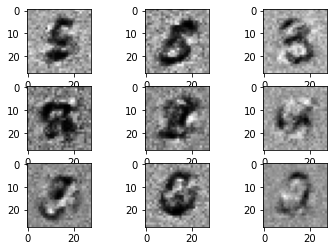

Epoch: 89
	Batch: 1	Discriminator Error: 0.407793	Generator Error: 3.296877
	Batch: 200	Discriminator Error: 0.370758	Generator Error: 3.319862
	Batch: 400	Discriminator Error: 0.469866	Generator Error: 3.117299
	Batch: 600	Discriminator Error: 0.494336	Generator Error: 2.937457


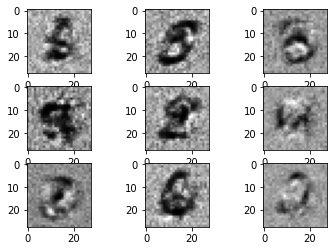

Epoch: 90
	Batch: 1	Discriminator Error: 0.302650	Generator Error: 3.173772
	Batch: 200	Discriminator Error: 0.215704	Generator Error: 2.970162
	Batch: 400	Discriminator Error: 0.411310	Generator Error: 3.011726
	Batch: 600	Discriminator Error: 0.322425	Generator Error: 2.936426


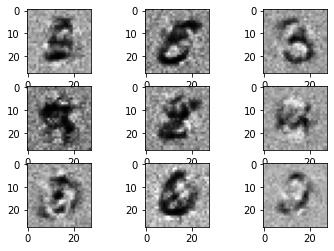

Epoch: 91
	Batch: 1	Discriminator Error: 0.252933	Generator Error: 2.748451
	Batch: 200	Discriminator Error: 0.481388	Generator Error: 2.854350
	Batch: 400	Discriminator Error: 0.353596	Generator Error: 3.348812
	Batch: 600	Discriminator Error: 0.459394	Generator Error: 3.031369


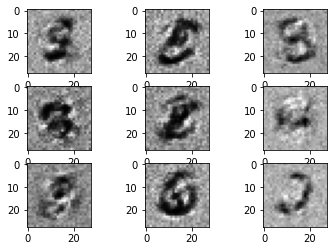

Epoch: 92
	Batch: 1	Discriminator Error: 0.392561	Generator Error: 2.998646
	Batch: 200	Discriminator Error: 0.265888	Generator Error: 3.214965
	Batch: 400	Discriminator Error: 0.199967	Generator Error: 3.089582
	Batch: 600	Discriminator Error: 0.369716	Generator Error: 2.925138


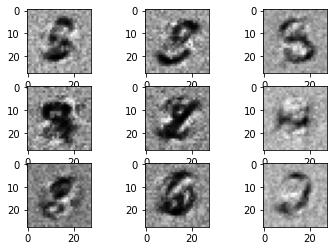

Epoch: 93
	Batch: 1	Discriminator Error: 0.317331	Generator Error: 3.188443
	Batch: 200	Discriminator Error: 0.304777	Generator Error: 3.109710
	Batch: 400	Discriminator Error: 0.240961	Generator Error: 3.080190
	Batch: 600	Discriminator Error: 0.282615	Generator Error: 3.210154


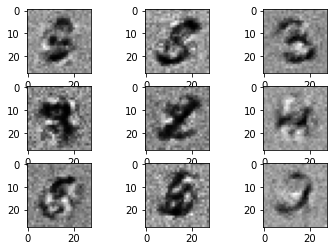

Epoch: 94
	Batch: 1	Discriminator Error: 0.245872	Generator Error: 3.294839
	Batch: 200	Discriminator Error: 0.381251	Generator Error: 2.973332
	Batch: 400	Discriminator Error: 0.326204	Generator Error: 3.039546
	Batch: 600	Discriminator Error: 0.305699	Generator Error: 3.321149


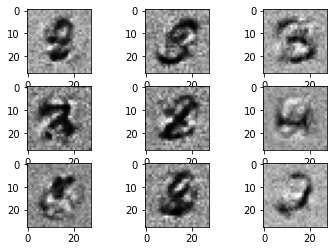

Epoch: 95
	Batch: 1	Discriminator Error: 0.255872	Generator Error: 3.175131
	Batch: 200	Discriminator Error: 0.484771	Generator Error: 3.244949
	Batch: 400	Discriminator Error: 0.512631	Generator Error: 3.233773
	Batch: 600	Discriminator Error: 0.428406	Generator Error: 3.179449


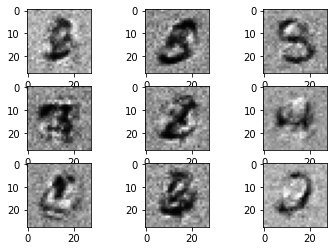

Epoch: 96
	Batch: 1	Discriminator Error: 0.251365	Generator Error: 3.039366
	Batch: 200	Discriminator Error: 0.494142	Generator Error: 3.105027
	Batch: 400	Discriminator Error: 0.367490	Generator Error: 3.123080
	Batch: 600	Discriminator Error: 0.294719	Generator Error: 3.160510


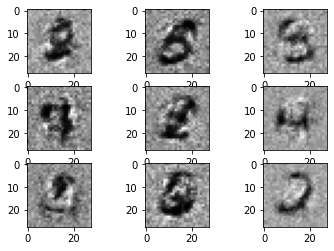

Epoch: 97
	Batch: 1	Discriminator Error: 0.359003	Generator Error: 3.120818
	Batch: 200	Discriminator Error: 0.289764	Generator Error: 3.350051
	Batch: 400	Discriminator Error: 0.423646	Generator Error: 3.181998
	Batch: 600	Discriminator Error: 0.350961	Generator Error: 3.076703


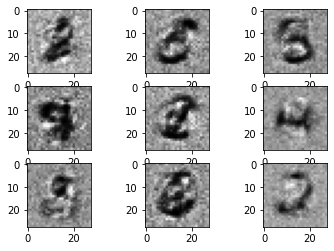

Epoch: 98
	Batch: 1	Discriminator Error: 0.259336	Generator Error: 3.118540
	Batch: 200	Discriminator Error: 0.406737	Generator Error: 3.205582
	Batch: 400	Discriminator Error: 0.306951	Generator Error: 3.272790
	Batch: 600	Discriminator Error: 0.500825	Generator Error: 2.880878


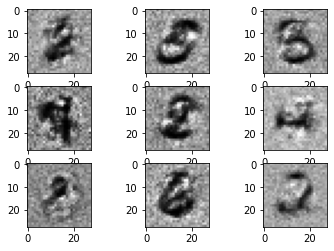

Epoch: 99
	Batch: 1	Discriminator Error: 0.348637	Generator Error: 3.094695
	Batch: 200	Discriminator Error: 0.329233	Generator Error: 3.569249
	Batch: 400	Discriminator Error: 0.302520	Generator Error: 3.226957
	Batch: 600	Discriminator Error: 0.286752	Generator Error: 3.128922


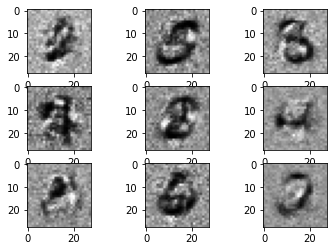

In [36]:
epochs = 100

for epoch in range(epochs):
    print("Epoch: %d" %(epoch))
    for n, batch in enumerate(trainloader):
        batch = [t.to(device) for t in batch]
        real_batch = batch[0]
        N = real_batch.size(0)
        real_data = real_batch.reshape(batch_size,784)
        fake_data = generator(noise(batch_size).to(device))
        d_error, d_pred_real, d_pred_fake = train_discriminator(discrim_optim, criterion_d, real_data, fake_data)
    
        fake_data = generator(noise(batch_size).to(device))
        g_error = train_generator(generate_optim, criterion_g, fake_data)

        if (n + 1) % 200 == 0 or n == 0: 
            print("\tBatch: %d\tDiscriminator Error: %f\tGenerator Error: %f" %(n + 1, d_error, g_error))
            gen_err.append(g_error)
            dis_err.append(d_error)
            if (n + 1) % 600 == 0:
                validation_images = generator(validation_noise.to(device)).detach().cpu().numpy()
                fig, axs = plt.subplots(3, 3)
                for i in range(9):
                    plotimg(validation_images[i], axs, int(i/3), i%3)
                plt.show()

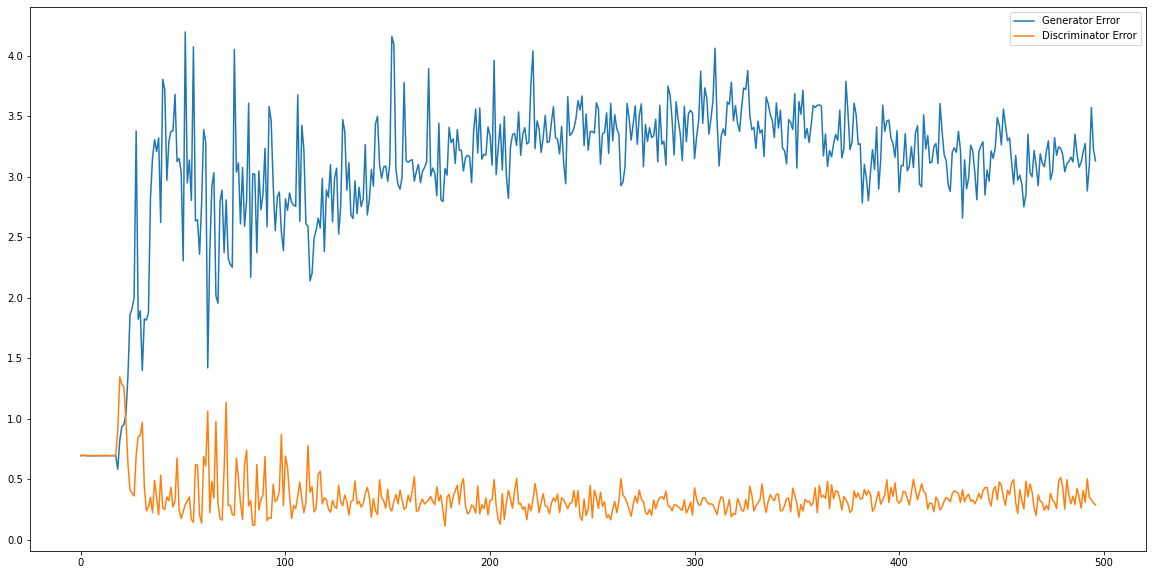

In [37]:
plt.figure(figsize=(20, 10))
plt.plot(gen_err, label="Generator Error")
plt.plot(dis_err, label="Discriminator Error")
plt.legend()
plt.show()

In [39]:
torch.save(generator.state_dict(), '/content/drive/MyDrive/generator.pt')
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/discriminator.pt')

In [40]:

path = '/content/drive/MyDrive/generator.pt'
generator.load_state_dict(torch.load(path))

<All keys matched successfully>

In [41]:
path = '/content/drive/MyDrive/discriminator.pt'
discriminator.load_state_dict(torch.load(path))

<All keys matched successfully>

##**Generated Digits**

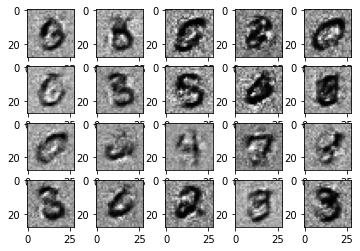

In [42]:
test_images = generator(noise(20).to(device)).detach().cpu().numpy()
fig, axis = plt.subplots(4, 5)
for i in range(20):
    plotimg(test_images[i], axis, int(i/5), i%5)
plt.show()